# Hyperparameters and Model Validation

Basic recipe for applying supervised machine learning:
1. Choose the model
2. Choose model hyperparameters
3. Fit the model to training data
4. Use the model to predict labels for new data

The first two pieces of this—the choice of model and choice of hyperparameters—are perhaps the most important part of using these tools and techniques effectively. In order to make an informed choice, we need a way to validate that our model and our hyperparameters are a good fit to the data. While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

__Import libraries and utilities__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

---

## Thinking About Model Validation

### Model validation the wrong way

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. Here we’ll use a k-neighbors classifier with n_neighbors=1. This is a very simple and intuitive model that says “the label of an unknown point is the same as the label of its closest training point”

In [3]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X, y)
y_model = model.predict(X)

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y_model, y)

1.0

__What is the fallacies of thinking?__

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model! But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time? As you may have gathered, the answer is no. In fact, this approach contains a fundamental flaw: it trains and evaluates the model on the same data. Furthermore, the nearest neighbor model is an instance-based estimator that simply stores the training data, and predicts labels by comparing new data to these stored points; except in contrived cases, it will get 100% accuracy every time!
<br> <br>
So... don't do this!!!

### Model validation the right way: Holdout sets

We can get a better sense of a model’s performance using what’s known as a holdout set; that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.

In [5]:
from sklearn.model_selection import train_test_split
# splitting the data into train set and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=21)

# fit the model to train set
model.fit(Xtrain, ytrain)

# evaluate the model
y2_model = model.predict(Xtest)
accuracy_score(y2_model, ytest)

0.9473684210526315

We see that we can prevent the fallicies of thinking by splitting the dataset into training set and test set

### Model validation via cross-validation

By using holdout sets we lose several of our dataset, and that could be a problem when our dataset is small. <br>
One way to address this is to use cross-validation—that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.

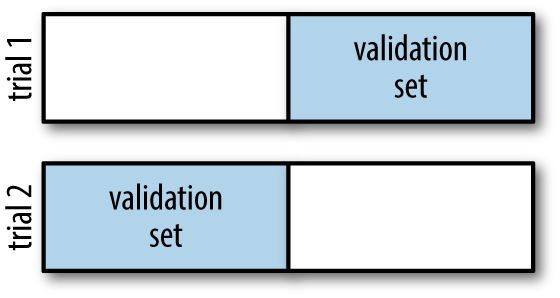

In [6]:
y2_model = model.fit(Xtrain, ytrain).predict(Xtest)
y1_model = model.fit(Xtest, ytest).predict(Xtrain)
accuracy_score(ytrain, y1_model), accuracy_score(ytest, y2_model)

(0.9285714285714286, 0.9473684210526315)

This particular form of cross-validation is a two-fold cross-validation—one in which we have split the data into two sets and used each in turn as a validation set.

For make a general idea, this is the five-fold-cross-validation: 
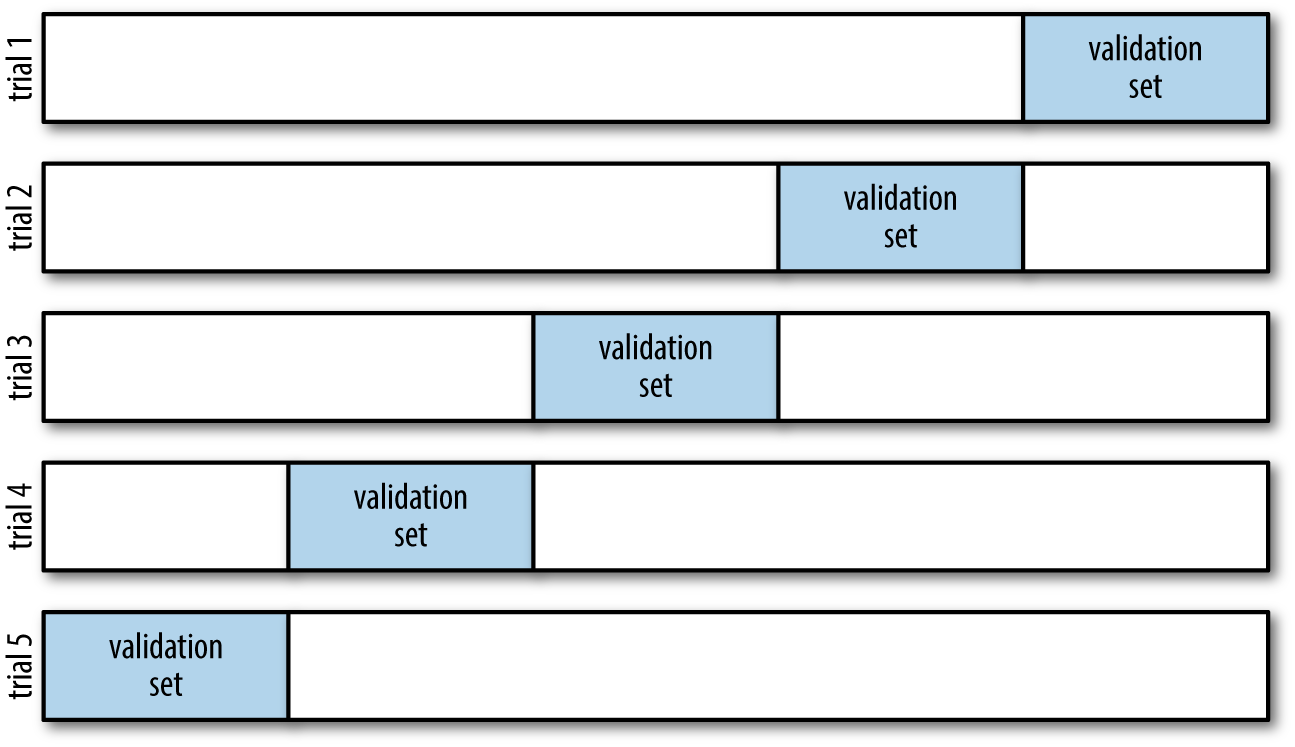

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

__leave-one-out-cross-validation__ <br>
We train all points but one.

In [8]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
scores.mean()

0.96

---

## Selecting the Best Model

Of core importance is the following question: if our estimator is underperforming, how should we move forward? There are several possible answers:

• Use a more complicated/more flexible model <br>
• Use a less complicated/less flexible model <br>
• Gather more training samples <br>
• Gather more data to add features to each sample

The answer to this question is often counterintuitive. In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results! The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

### The bias-variance trade-off

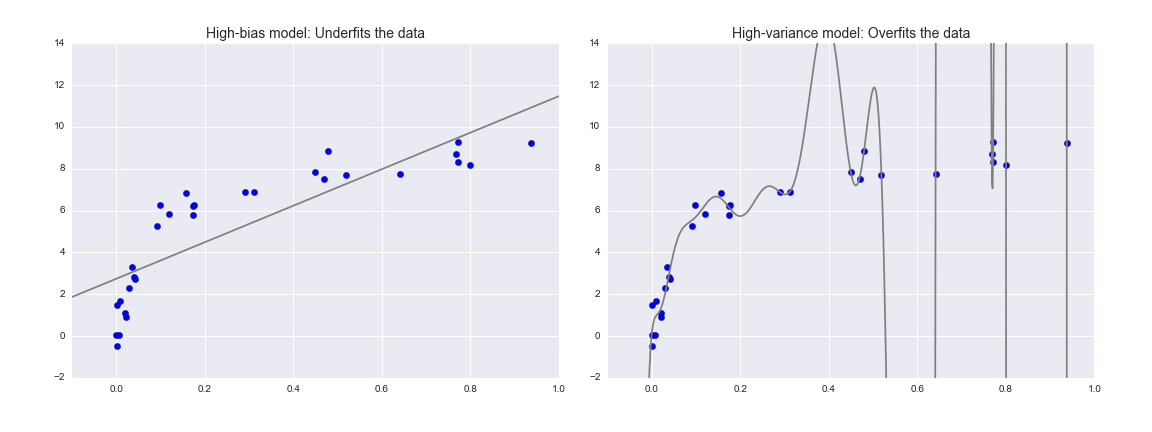

The model on the left attempts to find a straight-line fit through the data. Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well. Such a model is said to underfit the data; that is, it does not have enough model flexibility to suitably account for all the features in the data. Another way of saying this is that the model has high bias.

What happens if we use the model to predict new data?
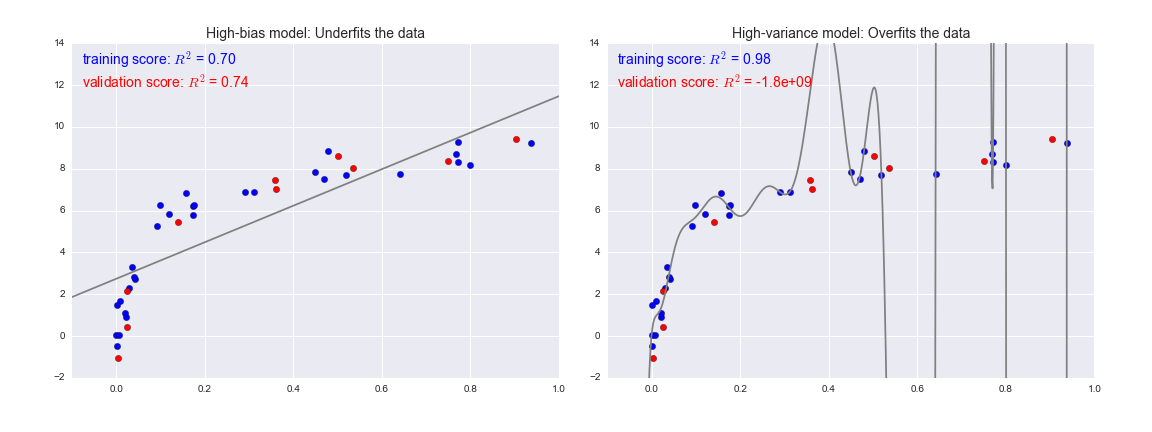

The score here is the R2 score, or coefficient of determination, which measures how well a model performs relative to a simple mean of the target values. R2 = 1 indicates a perfect match, R2 = 0 indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models. From the scores associated with these two models, we can make an observation that holds more generally: <br>
• For high-bias models, the performance of the model on the validation set is similar to the performance on the training set. <br>
• For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

__Validation Curve__

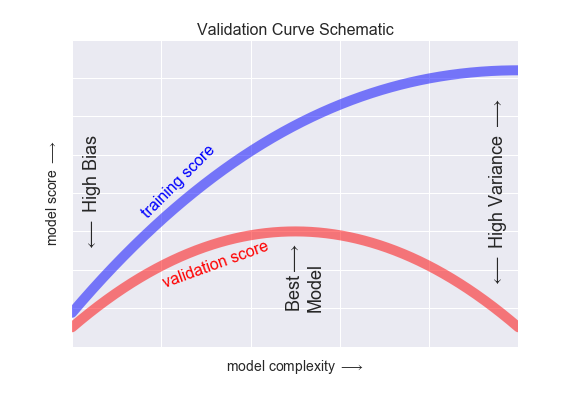

• The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen. <br>
• For very low model complexity (a high-bias model), the training data is underfit, which means that the model is a poor predictor both for the training data and for any previously unseen data. <br>
• For very high model complexity (a high-variance model), the training data is overfit, which means that the model predicts the training data very well, but fails for any previously unseen data. <br>
• For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

### Validation curves in Scikit-Learn

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
    LinearRegression(**kwargs))

In [11]:
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

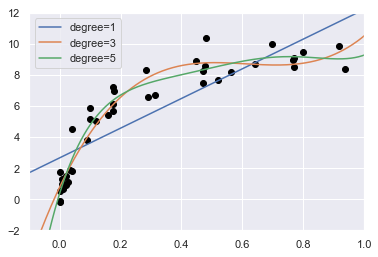

In [12]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

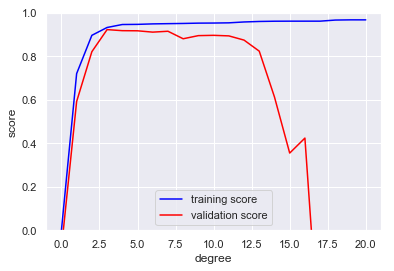

In [13]:
# make validation curve
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(),X, y,
                                          'polynomialfeatures__degree',
                                         degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

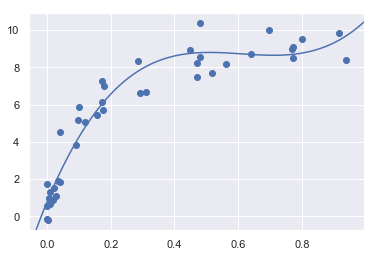

In [14]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

---

## Learning Curves

Now, consider the validation problem that depends on the number of data we have.

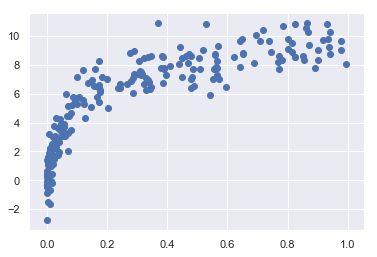

In [15]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

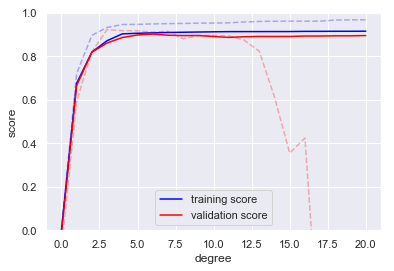

In [16]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree',
                                            degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue',
                           label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', 
                           label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3,
                           linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3,
                           linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Thus we see that the behavior of the validation curve has not one, but two, important inputs: the model complexity and the number of training points. It is often useful to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model. A plot of the training/validation score with respect to the size of the training set is known as a learning curve.

The general behavior we would expect from a learning curve is this: <br>
• A model of a given complexity will overfit a small dataset: this means the training score will be relatively high, while the validation score will be relatively low. <br>
• A model of a given complexity will underfit a large dataset: this means that the training score will decrease, but the validation score will increase. <br>
• A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

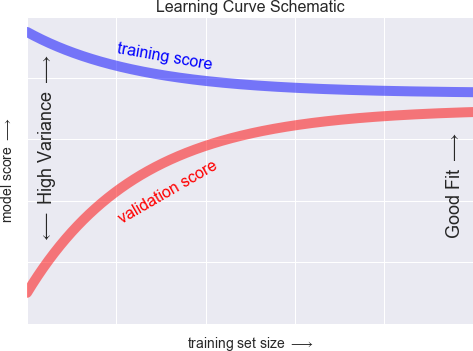

In particular, once you have enough points that a particular model has converged, adding more training data will not help you! The only way to increase model performance in this case is to use another (oftenmore complex) model.

### Learning curves in Scikit-Learn

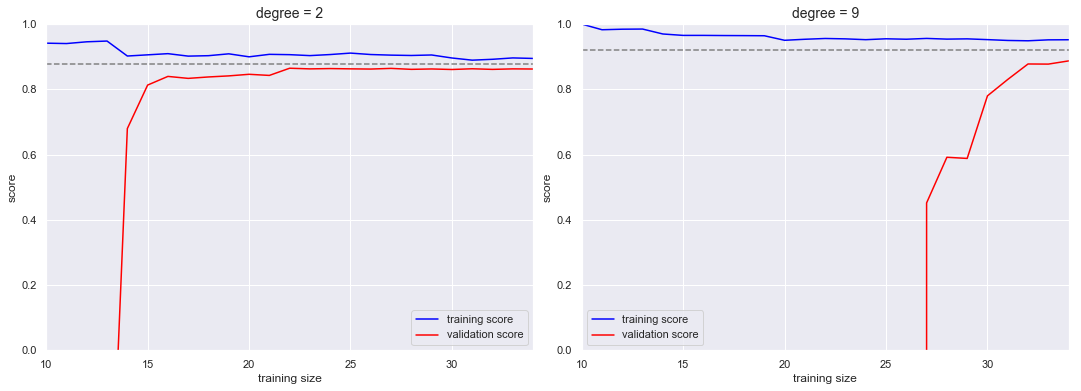

In [17]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))
    
    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray',
                 linestyle='dashed')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data. In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other), adding more training data will not significantly improve the fit! This situation is seen in the left panel, with the learning curve for the degree-2 model.

The only way to increase the converged score is to use a different (usually more complicated) model. We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores). If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

---

## Validation in Practice: Grid Search

Here we use grid search to dng the optimal polynomial model.

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
            'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [19]:
grid.fit(X, y);

C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [20]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

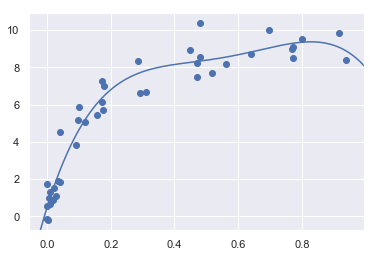

In [21]:
model = grid.best_estimator_
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);